In [1]:
import numpy as np
import pandas as pd

pokemon = pd.read_csv("dataset/pokemon.csv")

In [2]:
# Type1 and Type2 unique and remove nan
types = pokemon[["Type1", "Type2"]].dropna().melt()["value"].unique()

In [3]:
print(types)

['Grass' 'Fire' 'Bug' 'Normal' 'Poison' 'Water' 'Rock' 'Electric' 'Ghost'
 'Ground' 'Psychic' 'Ice' 'Dragon' 'Fairy' 'Dark' 'Steel' 'Fighting'
 'Flying']


In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([types])

for i, label in enumerate(mlb.classes_):
    print(f"{i:2}: {label}")

 0: Bug
 1: Dark
 2: Dragon
 3: Electric
 4: Fairy
 5: Fighting
 6: Fire
 7: Flying
 8: Ghost
 9: Grass
10: Ground
11: Ice
12: Normal
13: Poison
14: Psychic
15: Rock
16: Steel
17: Water


In [5]:
pokemon["Type"] = pokemon.apply(
    lambda row: [row["Type1"]] if pd.isnull(row["Type2"]) else [row["Type1"], row["Type2"]],
    axis=1
)

In [6]:
pokemon.head()

,Name,Type1,Type2,Type
0,bulbasaur,Grass,Poison,"[Grass, Poison]"
1,ivysaur,Grass,Poison,"[Grass, Poison]"
2,venusaur,Grass,Poison,"[Grass, Poison]"
3,charmander,Fire,NaN,[Fire]
4,charmeleon,Fire,NaN,[Fire]


In [7]:
pokemon["TypeBin"] = pokemon["Type"].apply(lambda x: mlb.transform([x])[0])

In [8]:
pokemon.head()

,Name,Type1,Type2,Type,TypeBin
0,bulbasaur,Grass,Poison,"[Grass, Poison]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ..."
1,ivysaur,Grass,Poison,"[Grass, Poison]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ..."
2,venusaur,Grass,Poison,"[Grass, Poison]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ..."
3,charmander,Fire,NaN,[Fire],"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,charmeleon,Fire,NaN,[Fire],"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
# calculate the mean and std value of pokemon images for transformation
from PIL import Image
import os

image_dir = "dataset/images"
image_files = os.listdir(image_dir)

image_pixels = []

for image_file in image_files:
    image = Image.open(os.path.join(image_dir, image_file)).convert("RGBA")
    image = np.asarray(image)[:, :, :3]
    image_pixels.append(image)

image_mean = np.mean(image_pixels, axis=(0, 1, 2)) / 255
image_std = np.std(image_pixels, axis=(0, 1, 2)) / 255
print(image_mean, image_std)

[0.18961068 0.1856215  0.17901835] [0.35844862 0.35119924 0.34517958]


In [50]:
# # delete Type column
# pokemon_tosave = pokemon.drop("Type", axis=1)
# # save the processed data
# pokemon_tosave.to_pickle("dataset/pokemon_processed.pkl")

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from transformers import ViTModel, ViTConfig
import pandas as pd
import numpy as np
import os
from PIL import Image

# load the processed data
pokemon = pd.read_pickle("dataset/pokemon_processed.pkl")

# define the transformation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.18961068, 0.1856215, 0.17901835,), 
        (0.35844862, 0.35119924, 0.34517958,)
    ),
    # the following lines are used to image augmentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20)
])
vit_train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5)
    ),
    # the following lines are used to image augmentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.18961068, 0.1856215, 0.17901835,), 
        (0.35844862, 0.35119924, 0.34517958,)
    )
])
vit_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5)
    )
])

# define the dataset
class PokemonDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.pokemon_names = pd.read_csv(csv_file, header=None)[0]
        self.image_dir = image_dir
        self.transform = transform
        items = os.listdir(image_dir)
        self.image_names = [item for item in items if item.split(".")[0] in self.pokemon_names.values]
        self.images = [np.array(Image.open(os.path.join(image_dir, image_name)).convert("RGBA"))[:, :, :3] for image_name in self.image_names]
        self.labels = [pokemon.loc[pokemon["Name"] == image_name.split(".")[0], "TypeBin"].values[0] for image_name in self.image_names]
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        # prepare image
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)

        # prepare label
        label = self.labels[idx]
        
        return image, label


/home/uzu/software/miniforge3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the dataset
train_dataset = PokemonDataset(
    csv_file="dataset/train.csv",
    image_dir="dataset/images",
    transform=train_transform
)

vit_train_dataset = PokemonDataset(
    csv_file="dataset/train.csv",
    image_dir="dataset/images",
    transform=vit_train_transform
)

leak_dataset = PokemonDataset(
    csv_file="dataset/leak.csv",
    image_dir="dataset/images",
    transform=train_transform
    # transform=test_transform
)

test_dataset = PokemonDataset(
    csv_file="dataset/test.csv",
    image_dir="dataset/images",
    transform=test_transform
)

vit_test_dataset = PokemonDataset(
    csv_file="dataset/test.csv",
    image_dir="dataset/images",
    transform=vit_test_transform
)

In [3]:
# define the dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
vit_train_dataloader = DataLoader(vit_train_dataset, batch_size=128, shuffle=True)
leak_dataloader = DataLoader(leak_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
vit_test_dataloader = DataLoader(vit_test_dataset, batch_size=32, shuffle=False)

In [4]:
# try to get one batch
for images, labels in train_dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([256, 3, 120, 120])
torch.Size([256, 18])


In [5]:
# define the model to predict pokemon type
# using alexnet
# input size: 120 * 120 * 3
class PokemonClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PokemonClassifier, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=2), # 55 * 55 * 96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 27 * 27 * 96
            nn.Conv2d(96, 256, kernel_size=5, padding=1), # 25 * 25 * 256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 12 * 12 * 256
            nn.Conv2d(256, 384, kernel_size=3, padding=1), # 12 * 12 * 384
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), # 12 * 12 * 384
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # 12 * 12 * 256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 5 * 5 * 256
        )

        self.flatten = nn.Flatten()

        self.dense = nn.Sequential(
            nn.Linear(5 * 5 * 256, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x
    
    def predict(self, images):
        with torch.no_grad():
            # predict
            if len(images.shape) == 3:
                images = images.unsqueeze(0)
            output = self(images)
            # take the top 2
            _, indices = torch.topk(output, 2)
            return indices.squeeze().tolist()


# class PokemonClassifier(nn.Module):
#     def __init__(self, num_classes):
#         super(PokemonClassifier, self).__init__()

#         self.features = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=3),        # 118 * 118 * 16
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),  # 59 * 59 * 16
#             nn.Conv2d(16, 32, kernel_size=3),       # 57 * 57 * 32
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(kernel_size=2, stride=2),  # 28 * 28 * 32
#             nn.Conv2d(32, 64, kernel_size=3),       # 26 * 26 * 64
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(64),
#             nn.MaxPool2d(kernel_size=2, stride=2),  # 13 * 13 * 64
#             nn.Conv2d(64, 128, kernel_size=3),      # 11 * 11 * 128
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(128),
#             nn.MaxPool2d(kernel_size=2, stride=2),  # 5 * 5 * 128
#             nn.Conv2d(128, 150, kernel_size=3),     # 3 * 3 * 150
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(150),
#             nn.MaxPool2d(kernel_size=2, stride=2),  # 1 * 1 * 150
#         )

#         self.flatten = nn.Flatten()

#         self.dense = nn.Sequential(
#             nn.Linear(150, 64),
#             nn.ReLU(inplace=True),
#             nn.Linear(64, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.flatten(x)
#         x = self.dense(x)
#         return x
    
#     def predict(self, images):
#         with torch.no_grad():
#             # predict
#             if len(images.shape) == 3:
#                 images = images.unsqueeze(0)
#             output = self(images)
#             # take the top 2
#             _, indices = torch.topk(output, 2)
#             return indices.squeeze().tolist()



class ViTClassifier(nn.Module):
    def __init__(
        self,
        num_classes,
        config=ViTConfig(),
        model_checkpoint="google/vit-base-patch16-224-in21k"
    ):
        super(ViTClassifier, self).__init__()

        self.vit = ViTModel.from_pretrained(model_checkpoint, config=config)

        self.dense = nn.Linear(config.hidden_size, num_classes)

    def forward(self, x):
        x = self.vit(x)['last_hidden_state'][:, 0, :]
        x = self.dense(x)
        return x
    
    def predict(self, images):
        with torch.no_grad():
            # predict
            if len(images.shape) == 3:
                images = images.unsqueeze(0)
            output = self(images)
            # take the top 2
            _, indices = torch.topk(output, 2)
            return indices.squeeze().tolist()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4

model = ViTClassifier(num_classes=pokemon["TypeBin"].values[0].shape[0]).to(device)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train the model
num_epochs = 500

In [7]:
type_dict = {
    0: "Bug",
    1: "Dark",
    2: "Dragon",
    3: "Electric",
    4: "Fairy",
    5: "Fighting",
    6: "Fire",
    7: "Flying",
    8: "Ghost",
    9: "Grass",
    10: "Ground",
    11: "Ice",
    12: "Normal",
    13: "Poison",
    14: "Psychic",
    15: "Rock",
    16: "Steel",
    17: "Water"
}

def decode_type(indices):
    return [type_dict[idx] for idx in indices]

def bin_to_indices(bin):
    return np.where(bin == 1)[0].tolist()

def decode_from_bin(bin):
    return decode_type(bin_to_indices(bin))

def list_to_str(name_list):
    name_list.sort()
    return ", ".join(name_list)

def test_model(dataloader=test_dataloader):
    num_correct = 0
    num_samples = 0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        pred_indices = model.predict(images)
        label_indices = [bin_to_indices(label) for label in labels.cpu().numpy()]
        for (pred, label) in zip(pred_indices, label_indices):
            pred.sort()
            label.sort()
            if (len(label) == 1):
                if label[0] in pred:
                    num_correct += 1
            else:
                if label == pred:
                    num_correct += 1
        num_samples += labels.size(0)
    return num_correct / num_samples * 100

In [8]:
is_leak = False

In [9]:
for epoch in range(num_epochs):
    model.train()
    # for i, (images, labels) in enumerate(train_loader if not is_leak else leak_loader):
    for i, (images, labels) in enumerate(vit_train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels.float())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    correct_rate = 0.0
    model.eval()
    with torch.no_grad():
        # correct_rate = test_model()
        correct_rate = test_model(vit_test_dataloader)

    print(f"Epoach [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy on test set: {correct_rate:.4f}")

/home/uzu/software/miniforge3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoach [1/500], Loss: 0.5148, Accuracy on test set: 4.9180
Epoach [2/500], Loss: 0.4454, Accuracy on test set: 13.9344
Epoach [3/500], Loss: 0.4253, Accuracy on test set: 16.3934
Epoach [4/500], Loss: 0.3991, Accuracy on test set: 15.5738
Epoach [5/500], Loss: 0.3810, Accuracy on test set: 14.7541
Epoach [6/500], Loss: 0.3670, Accuracy on test set: 14.7541
Epoach [7/500], Loss: 0.3617, Accuracy on test set: 12.2951
Epoach [8/500], Loss: 0.3481, Accuracy on test set: 13.1148
Epoach [9/500], Loss: 0.3390, Accuracy on test set: 15.5738
Epoach [10/500], Loss: 0.3225, Accuracy on test set: 17.2131
Epoach [11/500], Loss: 0.3241, Accuracy on test set: 18.0328
Epoach [12/500], Loss: 0.3165, Accuracy on test set: 15.5738
Epoach [13/500], Loss: 0.3035, Accuracy on test set: 15.5738
Epoach [14/500], Loss: 0.3159, Accuracy on test set: 16.3934
Epoach [15/500], Loss: 0.2993, Accuracy on test set: 18.8525
Epoach [16/500], Loss: 0.2991, Accuracy on test set: 21.3115
Epoach [17/500], Loss: 0.2798, Acc

KeyboardInterrupt: 

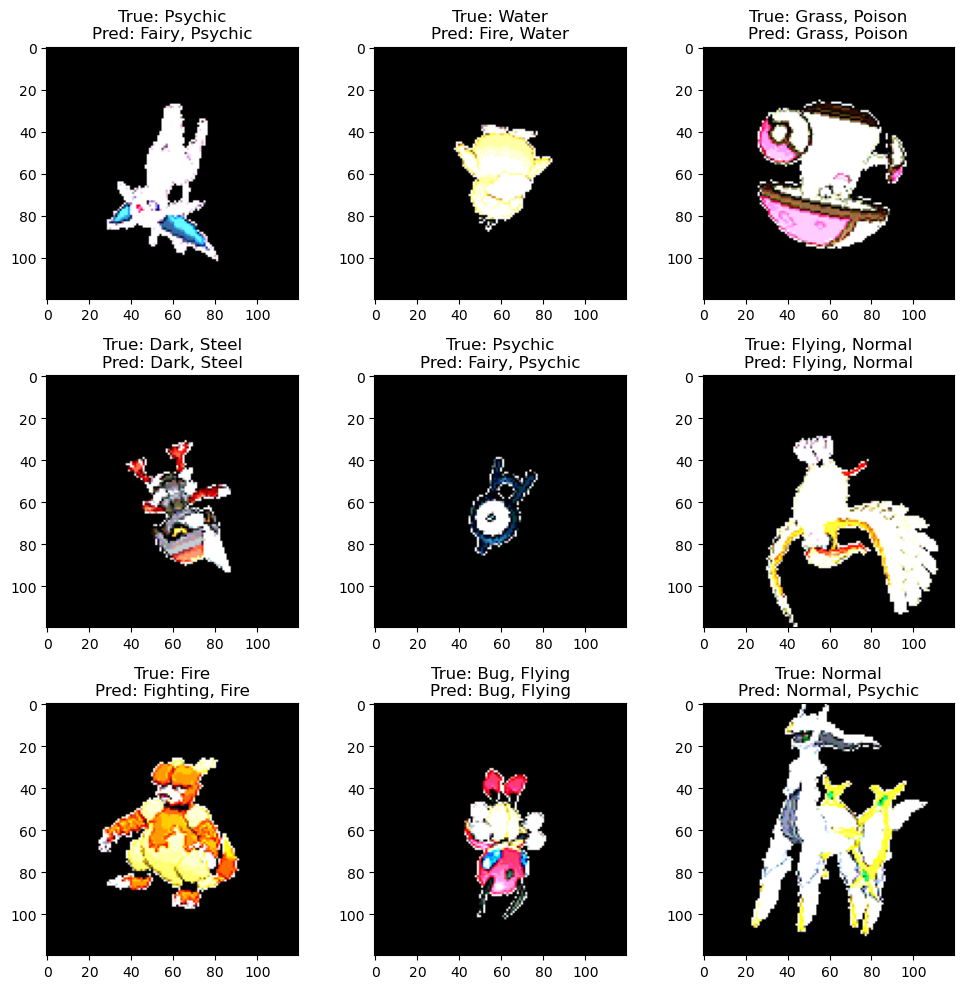

In [ ]:
import matplotlib.pyplot as plt

# plot some images in train dataset (first 9 images)
model.eval()
with torch.no_grad():
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    for i, (image, label) in enumerate(train_dataset):
        if i >= 9:
            break
        ax = axes[i//3, i%3]
        ax.imshow(np.clip(image.permute(1, 2, 0), 0, 1))
        true_label = decode_from_bin(label)
        pred_label = decode_type(model.predict(image.to(device)))
        ax.set_title(f"True: {list_to_str(true_label)}\nPred: {list_to_str(pred_label)}")

    plt.tight_layout()

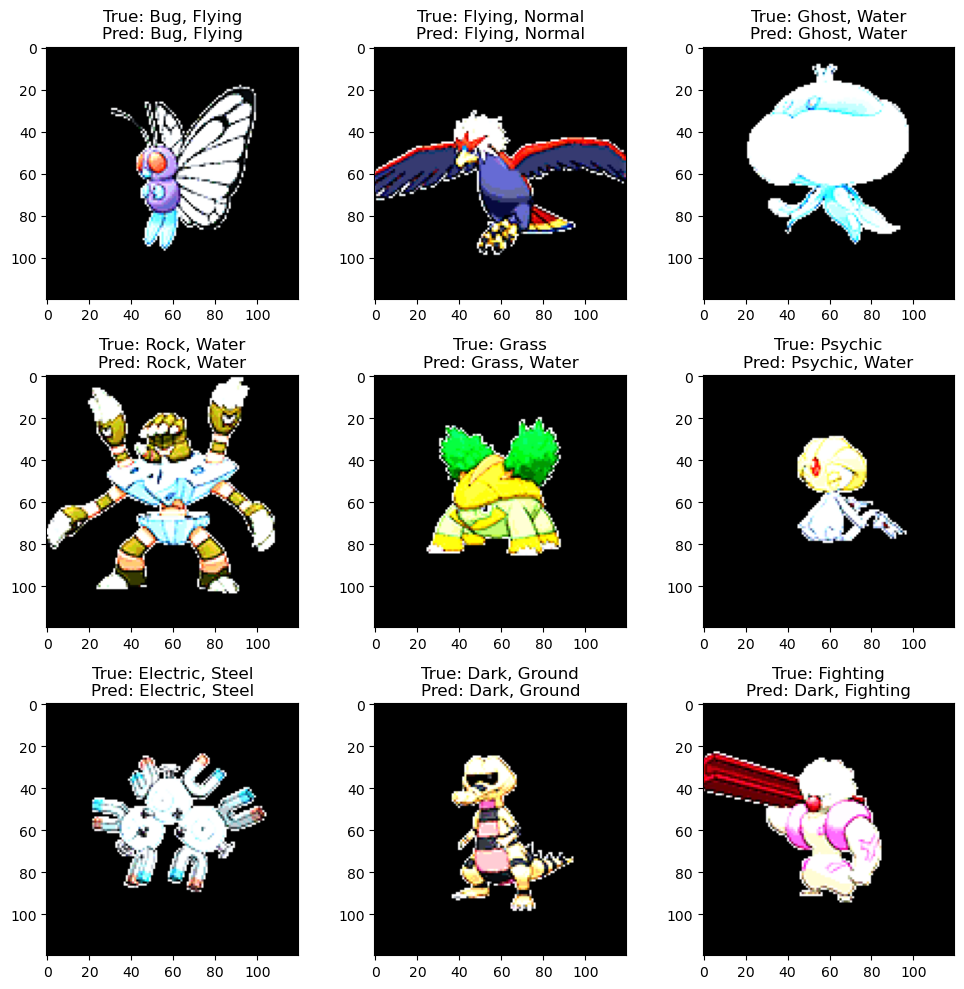

In [ ]:
# plot some images in test dataset (first 9 images)
model.eval()
with torch.no_grad():
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    for i, (image, label) in enumerate(test_dataset):
        if i >= 9:
            break
        ax = axes[i//3-3, i%3]
        ax.imshow(np.clip(image.permute(1, 2, 0), 0, 1))
        true_label = decode_from_bin(label)
        pred_label = decode_type(model.predict(image.to(device)))
        ax.set_title(f"True: {list_to_str(true_label)}\nPred: {list_to_str(pred_label)}")

plt.tight_layout()

In [ ]:
# calculate the accuracy on test dataset
correct_rate = 0.0
model.eval()
with torch.no_grad():
    correct_rate = test_model()

print(f"Accuracy on test set: {correct_rate:.2f}%")

Accuracy on test set: 98.36%
